# Fraud Transaction Prediction

### Importing Libraries

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scipy
from sklearn.metrics import classification_report,accuracy_score

### Importing Libraries for Outlier Detection

In [23]:
from sklearn.ensemble import IsolationForest

from sklearn.svm import OneClassSVM

### Reading our Dataset

In [24]:
df = pd.read_csv('Fraud.csv')
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


### Data Analysis

In [25]:
df.shape

(6362620, 11)

#### Checking Null Values

In [26]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

#### There is no missing and null values 

In [27]:
df['nameOrig'].value_counts()

C1902386530    3
C363736674     3
C545315117     3
C724452879     3
C1784010646    3
              ..
C98968405      1
C720209255     1
C1567523029    1
C644777639     1
C1280323807    1
Name: nameOrig, Length: 6353307, dtype: int64

In [28]:
df['nameDest'].value_counts()

C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
              ... 
M1470027725      1
M1330329251      1
M1784358659      1
M2081431099      1
C2080388513      1
Name: nameDest, Length: 2722362, dtype: int64

#### Text above 200000 is considered fraud by default

In [29]:
df['isFlaggedFraud'].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

### Checking the distribution of Normal and Fraud cases in our Data Set

In [30]:
fraud_check = pd.value_counts(df['isFraud'])
fraud_check

0    6354407
1       8213
Name: isFraud, dtype: int64


#### Let us see what is the shape of Normal and Fraud data set

In [31]:
fraud_people = df[df['isFraud']==1]
normal_people = df[df['isFraud']==0]

In [32]:
fraud_people.shape

(8213, 11)

In [33]:
normal_people.shape

(6354407, 11)

#### Finding out the avg amount in our both the data sets

In [34]:
fraud_people['amount'].describe()

count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64

In [35]:
normal_people['amount'].describe()

count    6.354407e+06
mean     1.781970e+05
std      5.962370e+05
min      1.000000e-02
25%      1.336840e+04
50%      7.468472e+04
75%      2.083648e+05
max      9.244552e+07
Name: amount, dtype: float64

#### Let us analyse it visually

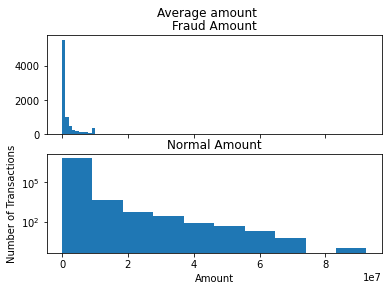

In [36]:
graph, (plot1, plot2) = plt.subplots(2,1,sharex= True)
graph.suptitle('Average amount ')
bins = 10

plot1.hist(fraud_people['amount'] , bins = bins)
plot1.set_title('Fraud Amount')

plot2.hist(normal_people['amount'] , bins = bins)
plot2.set_title('Normal Amount')

plt.xlabel('Amount')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show();

In [37]:
df['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

#### Converting payment type to Different columns so our model can get them as inputs 

In [38]:
from sklearn.preprocessing import OneHotEncoder

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding on 'team' column 
encoder_df = pd.DataFrame(encoder.fit_transform(df[['type']]).toarray())

#merge one-hot encoded columns back with original DataFrame
final_df = df.join(encoder_df)

#view final df
final_df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,0,1,2,3,4
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0.0,0.0,0.0,1.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0.0,0.0,0.0,1.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0.0,0.0,0.0,0.0,1.0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,0.0,1.0,0.0,0.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,0.0,1.0,0.0,0.0,0.0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,0.0,0.0,0.0,0.0,1.0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,0.0,1.0,0.0,0.0,0.0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,0.0,0.0,0.0,0.0,1.0


##### We are removing the type column because we have already got its value and For the columns  'nameOrig','nameDest' they dont play important part as a fraudster can use different accounts for disposal so he doesnt get tracked.

In [39]:
final_df.drop(['type','nameOrig','nameDest'],axis=1,inplace=True)
final_df

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,0,1,2,3,4
0,1,9839.64,170136.00,160296.36,0.00,0.00,0,0,0.0,0.0,0.0,1.0,0.0
1,1,1864.28,21249.00,19384.72,0.00,0.00,0,0,0.0,0.0,0.0,1.0,0.0
2,1,181.00,181.00,0.00,0.00,0.00,1,0,0.0,0.0,0.0,0.0,1.0
3,1,181.00,181.00,0.00,21182.00,0.00,1,0,0.0,1.0,0.0,0.0,0.0
4,1,11668.14,41554.00,29885.86,0.00,0.00,0,0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,339682.13,0.00,0.00,339682.13,1,0,0.0,1.0,0.0,0.0,0.0
6362616,743,6311409.28,6311409.28,0.00,0.00,0.00,1,0,0.0,0.0,0.0,0.0,1.0
6362617,743,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,0,0.0,1.0,0.0,0.0,0.0
6362618,743,850002.52,850002.52,0.00,0.00,0.00,1,0,0.0,0.0,0.0,0.0,1.0


#### Plotting co relation , finding the co linearity and removing columns that have high co linearity as that will effect our model

In [40]:
cor_matrix = final_df.corr().abs()
cor_matrix

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,0,1,2,3,4
step,1.000000,0.022373,0.010058,0.010299,0.027665,0.025888,0.031578,0.003277,0.004077,0.012918,0.002869,0.004926,0.006925
amount,0.022373,1.000000,0.002762,0.007861,0.294137,0.459304,0.076688,0.012295,0.009621,0.004376,0.023379,0.197444,0.365896
oldbalanceOrg,0.010058,0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.003835,0.506761,0.200899,0.021450,0.189486,0.081593
newbalanceOrig,0.010299,0.007861,0.998803,1.000000,0.067812,0.041837,0.008148,0.003776,0.527373,0.210977,0.021872,0.193915,0.087355
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,0.005885,0.000513,0.076105,0.086028,0.009347,0.231455,0.130476
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,0.000529,0.034988,0.093476,0.006346,0.238315,0.191701
isFraud,0.031578,0.076688,0.010154,0.008148,0.005885,0.000535,1.000000,0.044109,0.019089,0.011256,0.002911,0.025697,0.053869
isFlaggedFraud,0.003277,0.012295,0.003835,0.003776,0.000513,0.000529,0.044109,1.000000,0.000842,0.001168,0.000128,0.001133,0.005245
0,0.004077,0.009621,0.506761,0.527373,0.076105,0.034988,0.019089,0.000842,1.000000,0.391047,0.042987,0.379522,0.160535
1,0.012918,0.004376,0.200899,0.210977,0.086028,0.093476,0.011256,0.001168,0.391047,1.000000,0.059625,0.526422,0.222672


In [41]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
upper_tri

C:\Users\saura\AppData\Local\Temp/ipykernel_14268/918335127.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,0,1,2,3,4
step,NaN,0.022373,0.010058,0.010299,0.027665,0.025888,0.031578,0.003277,0.004077,0.012918,0.002869,0.004926,0.006925
amount,NaN,NaN,0.002762,0.007861,0.294137,0.459304,0.076688,0.012295,0.009621,0.004376,0.023379,0.197444,0.365896
oldbalanceOrg,NaN,NaN,NaN,0.998803,0.066243,0.042029,0.010154,0.003835,0.506761,0.200899,0.021450,0.189486,0.081593
newbalanceOrig,NaN,NaN,NaN,NaN,0.067812,0.041837,0.008148,0.003776,0.527373,0.210977,0.021872,0.193915,0.087355
oldbalanceDest,NaN,NaN,NaN,NaN,NaN,0.976569,0.005885,0.000513,0.076105,0.086028,0.009347,0.231455,0.130476
newbalanceDest,NaN,NaN,NaN,NaN,NaN,NaN,0.000535,0.000529,0.034988,0.093476,0.006346,0.238315,0.191701
isFraud,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.044109,0.019089,0.011256,0.002911,0.025697,0.053869
isFlaggedFraud,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000842,0.001168,0.000128,0.001133,0.005245
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.391047,0.042987,0.379522,0.160535
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.059625,0.526422,0.222672


In [42]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
to_drop

['newbalanceOrig', 'newbalanceDest']

### Creating our Dependent and Independent Features

In [43]:
columns = final_df.columns.tolist()
# Making our Independent Features
columns = [var for var in columns if var not in to_drop]
# Making our Dependent Variable
target = "isFraud"
x= final_df[columns]
y= final_df[target]

In [48]:
x.shape

(6362620, 11)

In [45]:
y.shape

(6362620,)

In [46]:
x.head() ## Independent Variable

,step,amount,oldbalanceOrg,oldbalanceDest,isFraud,isFlaggedFraud,0,1,2,3,4
0,1,9839.64,170136.0,0.0,0,0,0.0,0.0,0.0,1.0,0.0
1,1,1864.28,21249.0,0.0,0,0,0.0,0.0,0.0,1.0,0.0
2,1,181.00,181.0,0.0,1,0,0.0,0.0,0.0,0.0,1.0
3,1,181.00,181.0,21182.0,1,0,0.0,1.0,0.0,0.0,0.0
4,1,11668.14,41554.0,0.0,0,0,0.0,0.0,0.0,1.0,0.0


In [47]:
y.head() ## Dependent Variable

0    0
1    0
2    1
3    1
4    0
Name: isFraud, dtype: int64

## Model building

### Splitting the data

In [49]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

### We wil be using the following Models for our Anamoly Detection:
- Isolation Forest

## Isolation Forest

#### One of the newest techniques to detect anomalies is called Isolation Forests. The algorithm is based on the fact that anomalies are data points that are few and different. As a result of these properties, anomalies are susceptible to a mechanism called isolation.

#### This method is highly useful and is fundamentally different from all existing methods. It introduces the use of isolation as a more effective and efficient means to detect anomalies than the commonly used basic distance and density measures. Moreover, this method is an algorithm with a low linear time complexity and a small memory requirement. It builds a good performing model with a small number of trees using small sub-samples of fixed size, regardless of the size of a data set.

#### Typical machine learning methods tend to work better when the patterns they try to learn are balanced, meaning the same amount of good and bad behaviors are present in the dataset.

#### How Isolation Forests Work The Isolation Forest algorithm isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. The logic argument goes: isolating anomaly observations is easier because only a few conditions are needed to separate those cases from the normal observations. On the other hand, isolating normal observations require more conditions. Therefore, an anomaly score can be calculated as the number of conditions required to separate a given observation.

#### The way that the algorithm constructs the separation is by first creating isolation trees, or random decision trees. Then, the score is calculated as the path length to isolate the observation

In [50]:
iso_forest= IsolationForest(n_estimators=100, max_samples=len(x_train),random_state=0, verbose=0)                        

In [51]:
iso_forest.fit(x_train,y_train)

C:\Users\saura\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


IsolationForest(max_samples=4453834, random_state=0)

In [54]:
import pickle

saved_model = pickle.dumps(iso_forest)s

In [52]:
ypred= iso_forest.predict(x_test)

C:\Users\saura\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [53]:
ypred

array([1, 1, 1, ..., 1, 1, 1])

#### Mapping the values as we want to have an output in 0 and 1

In [55]:
ypred[ypred == 1] = 0
ypred[ypred == -1] = 1

### Accuracy score and Matrix

In [56]:
print(accuracy_score(y_test,ypred))

0.9924286955164172


##### as we can se the performance of the model is 99.2 % . And its a good score

In [57]:
print(classification_report(y_test,ypred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1906351
           1       0.14      1.00      0.25      2435

    accuracy                           0.99   1908786
   macro avg       0.57      1.00      0.62   1908786
weighted avg       1.00      0.99      1.00   1908786



In [58]:
from sklearn.metrics import confusion_matrix

In [59]:
confusion_matrix(y_test, ypred)

array([[1891899,   14452],
       [      0,    2435]], dtype=int64)

### We can also print how many errors our model have

In [60]:
n_errors = (ypred != y_test).sum()
print("Isolation Forest have {} errors.".format(n_errors))

Isolation Forest have 14452 errors.
